<a href="https://colab.research.google.com/github/gorogoro-uk/TensorFlow/blob/master/TF_4_3_TimeSeries_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.2.0
Epoch 1/100
94/94 [==============================] - 2s 26ms/step - loss: 20.3828 - mae: 20.8828 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 27ms/step - loss: 20.3543 - mae: 20.8543 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 28ms/step - loss: 20.3218 - mae: 20.8218 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 27ms/step - loss: 20.2852 - mae: 20.7851 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 2s 26ms/step - loss: 20.2436 - mae: 20.7436 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 2s 27ms/step - loss: 20.1964 - mae: 20.6964 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 2s 26ms/step - loss: 20.1429 - mae: 20.6429 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 3s 27ms/step - loss: 20.0823 - mae: 20.5823 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 2s 26ms/step - loss: 20.0140 

(1e-08, 0.0001, 0.0, 30.0)

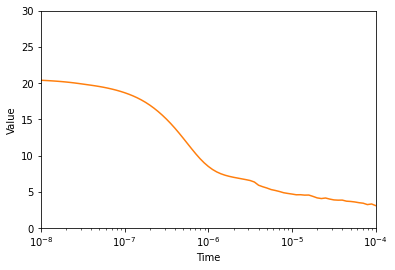

In [3]:
# TimeSeries data
# Bidirectional LSTM

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """arbitrary seasonal pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series & add noise
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=51)

# train, validation data sets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

# prepare windowed data sets
# makes batches, shuffles input, makes window chunks
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# 1. clear session for first model run to find optimal learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# define model
# bidrectional LSTM
# expand_dims to change input data shape
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0). # scale output to propoer range
])

# learning rate callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# Huber loss (less emphasis on extreme values)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# fit model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
# plot loss by learning rate to find best one
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])


In [7]:
# 2. clear session for second model run with best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])

# fit model & retain epoch history
history = model.fit(dataset,epochs=200,verbose=1)

Epoch 1/200
94/94 [==============================] - 2s 26ms/step - loss: 263.1985 - mae: 10.1378
Epoch 2/200
94/94 [==============================] - 2s 26ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/200
94/94 [==============================] - 2s 26ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/200
94/94 [==============================] - 2s 26ms/step - loss: 31.9160 - mae: 3.9759
Epoch 5/200
94/94 [==============================] - 2s 26ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/200
94/94 [==============================] - 2s 26ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/200
94/94 [==============================] - 3s 27ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/200
94/94 [==============================] - 3s 27ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/200
94/94 [==============================] - 2s 26ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/200
94/94 [==============================] - 3s 27ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/200
94/94 [=================

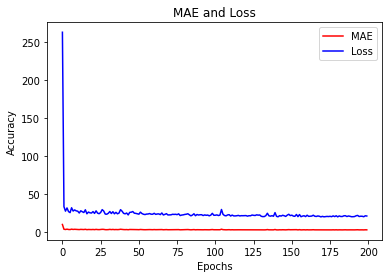

<Figure size 432x288 with 0 Axes>

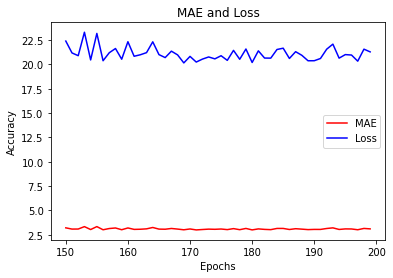

<Figure size 432x288 with 0 Axes>

In [8]:
# plot loss per epoch
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
plt.figure()
plt.show()

# plot loss zoomed version
epochs_zoom = epochs[150:]
mae_zoom = mae[150:]
loss_zoom = loss[150:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
plt.figure()
plt.show()


In [9]:
# forecast with LSTM model
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plt.title('forecast with LSTM model')
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


KeyboardInterrupt: ignored